In [20]:
import os
import regex as re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.sparse
import json
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [5]:
## functior to visualize a saprse scipi matrix
def spy(A, figsize=(4, 100), markersize=0.1):
    """Visualizes a sparse matrix."""
    fig = plt.figure(figsize=figsize)
    plt.spy(A, markersize=markersize)
    plt.show()

In [6]:
def rec2id(df):
    '''
    takes ingriedient list and returns a dict that maps ingredient ids to index
    '''
    recs = df['RecipeID'].unique()
    return {v:i for i,v in enumerate(recs) }

In [7]:
def id2rec(df):
    '''
    takes ingriedient list and returns a dict that maps ingredient ids to index
    '''
    recs = df['RecipeID'].unique()
    return {i:v for i,v in enumerate(recs) }

In [8]:
def user2id(df):
    '''
    takes ingriedient list and returns a dict that maps ingredient ids to index
    '''
    users = df['profileID'].unique()
    return { v:i for i,v in enumerate(users) }

In [9]:
def id2user(df):
    '''
    takes ingriedient list and returns a dict that maps ingredient ids to index
    '''
    users = df['profileID'].unique()
    return { i:v for i,v in enumerate(users) }

In [10]:
rev_filepath = os.getcwd() + '\\data\\reviews.csv'
rec_filepath = 'output.csv'

In [11]:
df_rev= pd.read_csv(rev_filepath, sep=';', error_bad_lines=False, warn_bad_lines=False, encoding= 'unicode_escape')
df_rec= pd.read_csv(rec_filepath, sep=',', error_bad_lines=False, warn_bad_lines=False, encoding= 'unicode_escape')['RecipeID']

In [12]:
df_rev['flag_num'] = df_rev['RecipeID'].apply(lambda x: 1 if str(x).isnumeric() else 0)
df_rev = df_rev[df_rev['flag_num']==1]
df_rev['RecipeID'] = df_rev['RecipeID'].astype(int)

del df_rev['flag_num']

In [13]:
df_rev['flag_num'] = df_rev['Rate'].apply(lambda x: 1 if str(x).isnumeric() else 0)
df_rev = df_rev[df_rev['flag_num']==1]
df_rev['Rate'] = df_rev['Rate'].astype(int)

del df_rev['flag_num']

In [14]:
df_m = df_rev.merge(df_rec, on='RecipeID' )[df_rev.columns]
df_m.head()

,RecipeID,profileID,Rate,Comment
0,7000,675719,5,'Oh Yay! I''ve never made any kind of bread f...
1,7000,1478626,5,These rolls are wonderful. I had to bake them ...
2,7000,608663,5,This recipe was made for a group of 120 in a c...
3,7000,2785736,5,WOO HOO.. I did it with the help from my fello...
4,7000,594474,5,"'These are great!! Not a croissant, but much l..."


In [15]:
df_m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 912548 entries, 0 to 912547
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   RecipeID   912548 non-null  int32 
 1   profileID  912548 non-null  object
 2   Rate       912548 non-null  int32 
 3   Comment    912430 non-null  object
dtypes: int32(2), object(2)
memory usage: 27.8+ MB


In [16]:
df_m = df_m.groupby(['profileID','RecipeID'])['Rate'].max().sort_values().reset_index().copy()

In [17]:
r2id = rec2id(df_m)
id2r = id2rec(df_m)
u2id = user2id(df_m)
id2u = id2user(df_m)

In [18]:
df_m['rid'] = df_m['RecipeID'].apply(lambda x: r2id[x])
df_m['uid'] = df_m['profileID'].apply(lambda x: u2id[x])

In [21]:
### build sparse csr matrix
rows = []
cols = []
vals = []

for user_id in tqdm(list(u2id.keys())[:10000]):
    s = df_m[df_m['profileID']==user_id][['uid','rid','Rate']]
    
    
    rows+=s['uid'].to_list()
    cols+=s['rid'].to_list()
    vals+=s['Rate'].to_list()



100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [27:37<00:00,  6.03it/s]


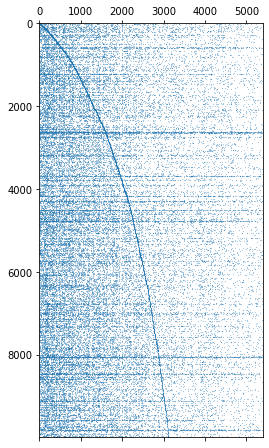

In [22]:
P = sp.sparse.csr_matrix((vals,(rows, cols)),shape=(np.max(rows)+1, np.max(cols)+1), dtype=float)
spy(P.A)


In [23]:
P=P.todense()

In [24]:
np.max(P)

5.0

## keep only top 500 similar users

In [25]:
from sklearn.metrics.pairwise import cosine_similarity
I = cosine_similarity(P, dense_output=True)

In [26]:
I-=np.identity(I.shape[0])

In [27]:
I.shape

(10000, 10000)

In [28]:
users = np.argsort(-I[0])[:500]
users

array([  90, 6730, 3691, 6571, 6810, 4462, 9907, 5978, 5729, 2602,   23,
       6847, 8939, 6164, 6751, 4045,   66, 7531, 1444, 2507, 6823, 4043,
       3509,  456, 4143, 8007,  272, 2161, 6954, 6361, 1900, 7954, 7997,
       6429, 3901, 2114, 9601, 7296, 9700,  619, 8362, 8446, 9654, 8875,
       4971, 2229, 2125, 1167, 6472, 1729, 2741, 4638, 7057, 6827,  586,
       7657, 6719, 3774, 5361, 7586, 3498, 5475, 8276, 1373, 8686, 5339,
       4183, 3361,  389, 9614, 2231, 5563, 2287, 3183, 8543, 3761, 9532,
       3571, 8253, 2156,   89, 4625, 6412, 8375, 8767, 3663, 2658, 2005,
       7752, 1092, 9329, 6701, 6702, 6666, 6669, 6665, 6670, 6668, 6700,
       6664, 6699, 6663, 6671, 6667, 6672, 6684, 6697, 6685, 6686, 6662,
       6687, 6683, 6688, 6682, 6681, 6680, 6689, 6679, 6690, 6678, 6677,
       6691, 6692, 6693, 6676, 6694, 6695, 6696, 6674, 6673, 6698, 6675,
       4999, 6660, 6610, 6611, 6612, 6613, 6614, 6615, 6609, 6616, 6618,
       6619, 6620, 6621, 6622, 6623, 6617, 6624, 66

In [29]:
P_new = P[users,:]
P_new.shape

(500, 5391)

In [30]:
P_new.max()

5.0

# matrix completion

In [33]:
#P_new = P_new_old.copy()

In [45]:
P_new_old = P_new.copy()

In [46]:
sample = [np.random.rand(P_new.shape[0],P_new.shape[1])<=0.1]
sample = np.multiply(sample[0],(P_new>0))

In [47]:
P_new_old[sample]

matrix([[1., 1., 5., 5., 3., 1., 1., 5., 5., 1., 5., 5., 5., 5., 5., 4.,
         4., 5., 5., 4., 3., 4., 4., 5., 4., 5., 5., 5., 4., 4., 4., 4.,
         5., 5., 1., 4., 4., 1., 5., 3., 5., 5., 5., 4., 5., 5., 4., 4.,
         5., 4., 4., 5., 2., 4., 3., 1., 2., 4., 3., 4., 1., 1., 3., 4.,
         1., 5., 5., 3., 5., 5., 4., 5., 4., 4., 3., 4., 1., 5., 4., 4.,
         5., 4., 4., 5., 4., 2., 1., 3., 4., 5., 5., 5., 5., 5., 5., 2.,
         4., 5., 4., 4., 3., 4., 4., 3., 4., 4., 4., 3., 4., 5., 5., 5.,
         3., 4., 3., 5., 2., 4., 4., 5., 5., 1., 2., 4., 5., 2., 4., 4.,
         5., 5., 5., 5., 5., 5., 4., 5., 4., 4., 5., 5., 4., 5., 5., 5.,
         5., 3., 4., 3., 1., 3., 4., 2., 4., 3., 3., 5., 5., 1., 5., 5.,
         4., 5., 5., 5., 4., 5., 4., 4., 4., 5., 3., 4., 3., 4., 3., 4.,
         4., 4., 5., 4., 4., 4., 4., 4., 1., 1., 5., 2., 4., 2., 4., 4.,
         4., 5., 5., 4., 5., 4., 5., 4., 3., 3., 4., 3., 4., 5., 5., 5.,
         4., 2., 1., 5., 5., 5., 5., 2., 2., 4., 5.

In [48]:
P_new[sample]=0

In [49]:
P_new

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [50]:
A = P_new==0
m=np.sum(A)

In [51]:
np.linalg.matrix_rank(P_new)

427

In [52]:
Y = np.zeros([P_new.shape[0], P_new.shape[1]])

In [53]:
m

2692104

In [54]:
delta = (P_new.shape[0]*P_new.shape[1])/m
tau=250

In [55]:
errors = []
from tqdm import tqdm
for i in tqdm(range(10000)):
    U,S,Vh = np.linalg.svd(Y, full_matrices=False)
    S_t = np.diag(S-tau)
    S_t[S_t<0] = 0
    Z = U@S_t@Vh
    H = P_new-Z
    H[A] = 0
    Y0 = Y.copy()
    Y = Y0+(delta*H)
    
    
    err = np.linalg.norm(Y-Y0, ord='fro')
    errors.append(err)
    
    if np.linalg.norm(Y-Y0, ord='fro')<0.01:
        break
    

 12%|████████▊                                                                  | 1181/10000 [09:45<1:12:48,  2.02it/s]


Text(0, 0.5, 'error')

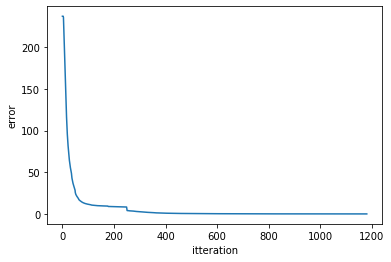

In [57]:
plt.plot(errors)
plt.xlabel('itteration')
plt.ylabel('error')


In [457]:
Z[Z<0] = 0

In [458]:
np.round(Z)

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]])

In [459]:
np.round(Z[sample])

matrix([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 2., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
         0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.

In [460]:
P_new_old[sample]

matrix([[5., 4., 5., 5., 5., 4., 5., 5., 5., 5., 4., 3., 4., 5., 4., 4.,
         4., 4., 4., 5., 5., 5., 5., 3., 5., 5., 5., 5., 3., 5., 4., 5.,
         5., 3., 4., 5., 1., 5., 4., 5., 5., 5., 5., 4., 3., 3., 4., 5.,
         5., 4., 5., 3., 2., 3., 5., 5., 5., 4., 4., 4., 1., 4., 4., 5.,
         5., 5., 4., 4., 3., 3., 5., 5., 4., 5., 4., 5., 5., 5., 2., 3.,
         4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 3., 4., 5., 2., 5., 4.,
         4., 5., 4., 4., 5., 5., 4., 3., 4., 4., 5., 5., 4., 4., 1., 4.,
         3., 4., 3., 2., 3., 3., 4., 3., 5., 5., 2., 1., 4., 1., 2., 4.,
         4., 3., 5., 4., 2., 4., 5., 2., 5., 5., 2., 4., 5., 4., 5., 4.,
         4., 5., 5., 5., 5., 3., 4., 4., 4., 4., 5., 4., 5., 4., 5., 3.,
         5., 1., 5., 3., 1., 4., 4., 4., 2., 3., 4., 2., 4., 5., 1., 3.,
         5., 5., 5., 5., 5., 5., 4., 1., 3., 5., 5., 5., 4., 2., 1., 4.,
         3., 1., 5., 5., 5., 5., 4., 5., 5., 4., 4., 5., 4., 5., 1., 3.,
         4., 5., 5., 4., 3., 4., 4., 3., 2., 4., 3.

In [486]:
sl = np.array(P_new_old[sample]).squeeze()
sl2 = np.array(np.round(Z[sample])).squeeze()
indexes = sl==5
np.sum(abs(sl[indexes]-sl2[indexes]))/len(indexes)

1.9862700228832952

In [488]:
err1 = []
err2 = []
err3 = []
err4 = []
err5 = []

for i in [1,2,3,4,5]:
    sl = np.array(P_new_old[sample]).squeeze()
    sl2 = np.array(np.round(Z[sample])).squeeze()
    indexes = sl==i
    print(f'MAE of {i}:-', np.sum(abs(sl[indexes]-sl2[indexes]))/len(indexes))

MAE of 1:- 0.12128146453089245
MAE of 2:- 0.11670480549199085
MAE of 3:- 0.32265446224256294
MAE of 4:- 1.139588100686499
MAE of 5:- 1.9862700228832952


In [490]:
np.linalg.norm(np.round(Z[sample])-P_new_old[sample])

82.18880702382776

In [489]:
np.sum(abs(np.round(Z[sample])-P_new_old[sample]))/len(Z[sample])

1611.0

In [463]:
new_preds =  np.round(Z) - P_new
new_preds

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]])

In [464]:
new_preds.shape

(500, 5391)

In [465]:
d = {}
for i, u in enumerate(users):
    rid = np.array(np.argsort(-new_preds[i])).squeeze()[0]
    d[id2u[u]] = (id2r[rid],new_preds[i,rid])

In [466]:
d

{'5782695': (22993, 0.0),
 '22164229': (22993, 0.0),
 '3293044': (22993, 0.0),
 '345724': (22993, 0.0),
 '1188483': (22993, 0.0),
 '10988293': (22993, 0.0),
 '1762473': (22993, 0.0),
 '1081973': (22993, 0.0),
 '5296684': (22993, 0.0),
 '1314371': (8873, 2.0),
 '8677808': (16354, 2.0),
 '4793729': (11802, 2.0),
 '4198459': (8148, 3.0),
 '3751061': (25539, 2.0),
 '562102': (12140, 3.0),
 '5957561': (10664, 5.0),
 '8684701': (20900, 3.0),
 '919748': (20577, 3.0),
 '476497': (13072, 4.0),
 '1303408': (15887, 3.0),
 '3842889': (13113, 4.0),
 '5957371': (21181, 3.0),
 '590126': (25688, 2.0),
 '1237011': (13032, 4.0),
 '4903888': (8635, 3.0),
 '1162973': (13459, 3.0),
 '474061': (16868, 5.0),
 '2669755': (11025, 3.0),
 '22149346': (22993, 0.0),
 '1181663': (25688, 3.0),
 '878171': (14065, 3.0),
 '9042694': (9599, 4.0),
 '1162606': (16047, 3.0),
 '896435': (20792, 3.0),
 '21110759': (16428, 4.0),
 '1307336': (22993, 0.0),
 '6593715': (22993, 0.0),
 '1147883': (22993, 0.0),
 '1477756': (22993, 

In [216]:
df_rec= pd.read_csv(rec_filepath, sep=',', error_bad_lines=False, warn_bad_lines=False, encoding= 'unicode_escape')

In [467]:
df_m[df_m['profileID']=='467747']

,profileID,RecipeID,Rate,rid,uid
3672,467747,7547,1,1842,3361
151894,467747,22310,4,3414,3361
151895,467747,22993,4,0,3361
152110,467747,20675,4,400,3361
152425,467747,10462,4,1475,3361
358636,467747,16110,5,3274,3361
358637,467747,10996,5,3422,3361
358665,467747,8333,5,189,3361


In [468]:
df_rec[df_rec['RecipeID'].isin(df_m[df_m['profileID']=='467747']['RecipeID'].to_list()+[9599])]

,RecipeID,Ingredients,ReviewCount,CookTimeMin,PrepTimeMin,RecipeName,yeast,water,white sugar,salt,...,vanilla very fine,red bean paste,chocolatehazelnut spread,loaf italian,cedar plank,pizza crust bread shell,buitoni pesto basil,brown sugar replacement,splenda granular,treacle
406,7547,1 package yellow cake mix. 3/4 cup vegetable o...,830,60,30,honey bun cake i recipe,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
972,8333,3/4 cup butter. 2 1/8 cups white sugar. 3 eggs...,2000,60,30,banana cake vi recipe,NaN,NaN,2.125,0.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926,9599,2 cups white sugar. 1 cup butter. 1/2 cup coco...,1000,30,15,quick and easy brownies recipe,NaN,NaN,2.000,0.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2550,10462,1 cup white sugar. 1 teaspoon baking powder. 3...,648,45,15,blueberry crumb bars recipe,NaN,NaN,0.500,0.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2971,10996,1/2 cup butter. 1/2 cup white sugar. 1/2 cup p...,96,28,15,monkey peanut butter bars recipe,NaN,NaN,0.500,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6568,16110,"2 cans garbanzo beans, drained. 2 cucumbers, h...",356,30,10,greek garbanzo bean salad recipe,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9141,20675,1 1/2 pounds lean ground beef. 1/2 cup crushed...,2000,45,10,rempel family meatloaf recipe,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9867,22310,1 package lemon cake mix. 1 package lemon flav...,134,35,15,creamy lemon cake recipe,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10164,22993,"3 fresh peaches - peeled, pitted, and sliced. ...",362,45,20,peach cobbler ii recipe,NaN,2.0,1.000,0.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
